#  Análisis de las Criptomonedas

En esta notebook vamos a esxplorar unos de los indicadores más importantes a las hora de hacer una inversión.

Indicators:
- ATR Average True Range
- Mooving Averages: 5, 15 and 30 period mooving average
- RSI Relative Strength Index

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import plotly.graph_objects as go
import time as t
from pycoingecko import CoinGeckoAPI
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as fplt

In [2]:
cg = CoinGeckoAPI()

In [4]:
lista_monedas = ['monero', 'bitcoin']

for moneda in lista_monedas:

    ohlc_data = cg.get_coin_ohlc_by_id(id = 'monero', vs_currency = 'usd', days = '180')

    ohlc_data_frame = pd.DataFrame(data = ohlc_data, columns = ['Date', 'Open', 'High' ,'Low', 'Close'])

    ohlc_data_frame['Date'] = ohlc_data_frame['Date'].apply(lambda x: dt.datetime.fromtimestamp(x/1000).strftime('%m-%d-%Y %H:%M:%S'))

    ohlc_data_frame['Date'] = pd.to_datetime(ohlc_data_frame['Date'])

    ohlc_data_frame = ohlc_data_frame.set_index('Date')

    ohlc_data_frame['moneda'] = moneda

    # Agregado atr
    def wwma(values, n):
        return values.ewm(alpha=1/n, adjust=False).mean()

    def atr(df, n=14):
        data = df.copy()
        high = data['High']
        low = data['Low']
        close = data['Close']
        data['tr0'] = abs(high - low)
        data['tr1'] = abs(high - close.shift())
        data['tr2'] = abs(low - close.shift())
        tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
        atr = wwma(tr, n)
        return atr

    ohlc_data_frame['ATR'] = atr(ohlc_data_frame)

    # agregado RSI
    ohlc_data_frame['change'] = ohlc_data_frame['Close'].diff()
    ohlc_data_frame['gain'] = ohlc_data_frame.change.mask(ohlc_data_frame.change < 0, 0.0)
    ohlc_data_frame['loss'] = -ohlc_data_frame.change.mask(ohlc_data_frame.change > 0, -0.0)

    def rma(x, n):
        """Running moving average"""
        a = np.full_like(x, np.nan)
        a[n] = x[1:n+1].mean()
        for i in range(n+1, len(x)):
            a[i] = (a[i-1] * (n - 1) + x[i]) / n
        return a

    ohlc_data_frame['avg_gain'] = rma(ohlc_data_frame.gain.to_numpy(), 14)
    ohlc_data_frame['avg_loss'] = rma(ohlc_data_frame.loss.to_numpy(), 14)

    ohlc_data_frame['rs'] = ohlc_data_frame.avg_gain / ohlc_data_frame.avg_loss
    ohlc_data_frame['RSI'] = 100 - (100 / (1 + ohlc_data_frame.rs))
    ohlc_data_frame = ohlc_data_frame.drop(['change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs'], axis=1)

    filename = f"{moneda}.csv"

    ohlc_data_frame.to_csv(filename, index=False)



In [84]:
def wwma(values, n):
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=14):
    data = df.copy()
    high = data['High']
    low = data['Low']
    close = data['Close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr

In [85]:
ohlc_data_frame['ATR'] = atr(ohlc_data_frame)

In [86]:
ohlc_data_frame['MA5'] = abs(ohlc_data_frame['Close'] - ohlc_data_frame['Open']).rolling(window = 5).mean()
ohlc_data_frame['MA15'] = abs(ohlc_data_frame['Close'] - ohlc_data_frame['Open']).rolling(window = 15).mean()
ohlc_data_frame['MA30'] = abs(ohlc_data_frame['Close'] - ohlc_data_frame['Open']).rolling(window = 30).mean()

In [87]:
ohlc_data_frame.tail()

,Open,High,Low,Close,ATR,MA5,MA15,MA30
Date,,,,,,,,
2023-07-30 21:00:00,162.15,163.29,160.23,160.23,5.395160,2.650,3.933333,2.763667
2023-08-02 21:00:00,161.59,161.59,159.60,159.60,5.151934,2.068,3.981333,2.755667
2023-08-06 21:00:00,160.45,160.45,158.51,159.59,4.922510,1.802,3.560000,2.781333
2023-08-10 21:00:00,158.27,158.94,155.97,155.97,4.829474,1.468,3.418000,2.852667
2023-08-14 21:00:00,156.75,158.18,156.75,158.18,4.642369,1.700,3.320000,2.744000


In [88]:
ohlc_data_frame['change'] = ohlc_data_frame['Close'].diff()
ohlc_data_frame['gain'] = ohlc_data_frame.change.mask(ohlc_data_frame.change < 0, 0.0)
ohlc_data_frame['loss'] = -ohlc_data_frame.change.mask(ohlc_data_frame.change > 0, -0.0)

#@numba.jit
def rma(x, n):
    """Running moving average"""
    a = np.full_like(x, np.nan)
    a[n] = x[1:n+1].mean()
    for i in range(n+1, len(x)):
        a[i] = (a[i-1] * (n - 1) + x[i]) / n
    return a

ohlc_data_frame['avg_gain'] = rma(ohlc_data_frame.gain.to_numpy(), 14)
ohlc_data_frame['avg_loss'] = rma(ohlc_data_frame.loss.to_numpy(), 14)

ohlc_data_frame['rs'] = ohlc_data_frame.avg_gain / ohlc_data_frame.avg_loss
ohlc_data_frame['RSI'] = 100 - (100 / (1 + ohlc_data_frame.rs))
ohlc_data_frame = ohlc_data_frame.drop(['change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs'], axis=1)

In [89]:
ohlc_data_frame

,Open,High,Low,Close,ATR,MA5,MA15,MA30,RSI
Date,,,,,,,,,
2023-02-18 21:00:00,156.64,161.75,156.64,161.75,5.110000,NaN,NaN,NaN,NaN
2023-02-22 21:00:00,161.68,161.68,157.71,157.71,5.033571,NaN,NaN,NaN,NaN
2023-02-26 21:00:00,151.85,151.85,148.90,151.39,5.303316,NaN,NaN,NaN,NaN
2023-02-27 21:00:00,149.73,152.46,149.73,151.13,5.119508,NaN,NaN,NaN,NaN
2023-03-06 21:00:00,144.74,153.95,144.74,153.95,5.411686,4.030,NaN,NaN,NaN
2023-03-10 21:00:00,150.43,150.43,135.20,135.20,6.364423,6.054,NaN,NaN,NaN
2023-03-14 21:00:00,140.38,152.79,140.38,150.41,7.166250,7.266,NaN,NaN,NaN
2023-03-18 21:00:00,147.04,154.15,147.04,150.19,7.162232,7.804,NaN,NaN,NaN
2023-03-22 21:00:00,154.69,154.69,149.79,149.79,7.000644,8.504,NaN,NaN,NaN


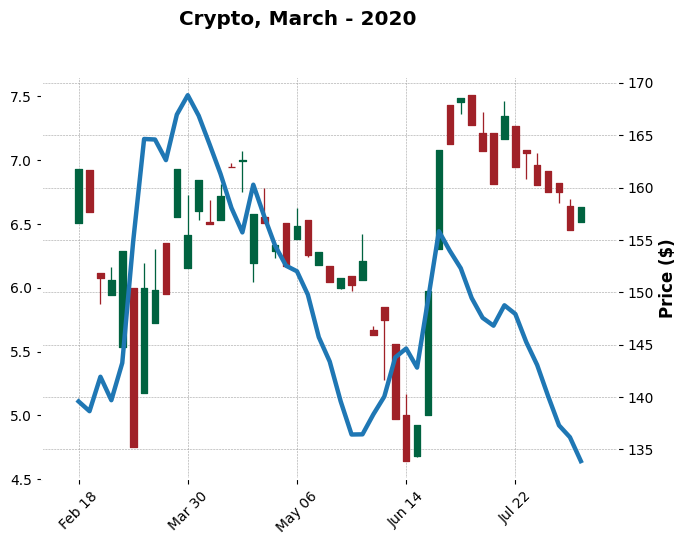

In [65]:
atr = fplt.make_addplot(ohlc_data_frame["ATR"])

fplt.plot(
            ohlc_data_frame,
            type='candle',
            addplot = atr,
            style='charles',
            title='Crypto, March - 2020',
            ylabel='Price ($)',
            )

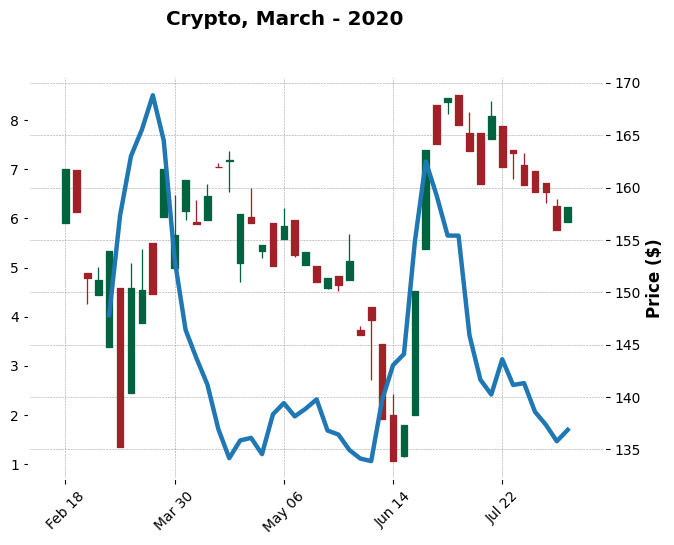

In [67]:
ma5 = fplt.make_addplot(ohlc_data_frame["MA5"])

fplt.plot(
            ohlc_data_frame,
            type='candle',
            addplot = ma5,
            style='charles',
            title='Crypto, March - 2020',
            ylabel='Price ($)',
            )

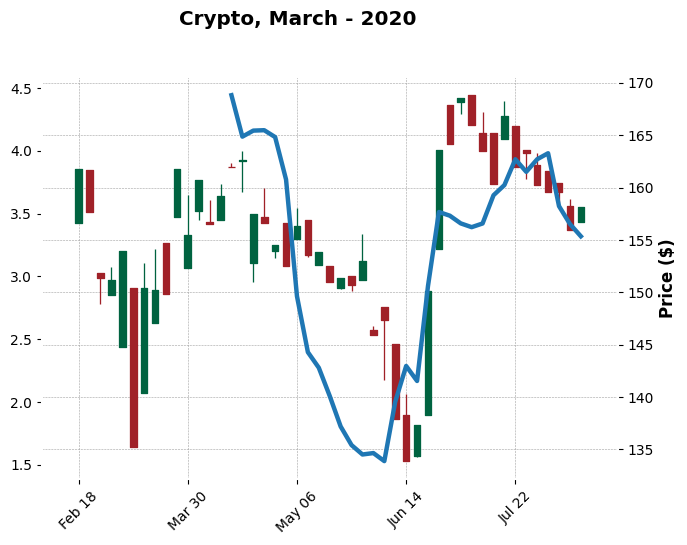

In [68]:
ma15 = fplt.make_addplot(ohlc_data_frame["MA15"])

fplt.plot(
            ohlc_data_frame,
            type='candle',
            addplot = ma15,
            style='charles',
            title='Crypto, March - 2020',
            ylabel='Price ($)',
            )

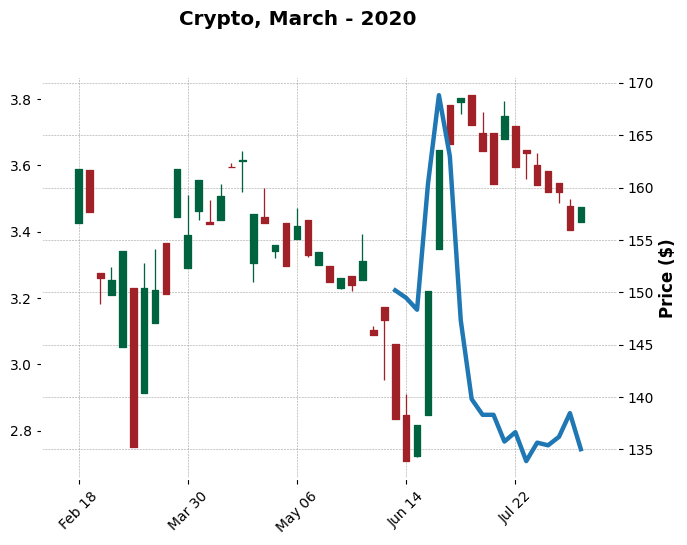

In [69]:
ma30 = fplt.make_addplot(ohlc_data_frame["MA30"])

fplt.plot(
            ohlc_data_frame,
            type='candle',
            addplot = ma30,
            style='charles',
            title='Crypto, March - 2020',
            ylabel='Price ($)',
            )

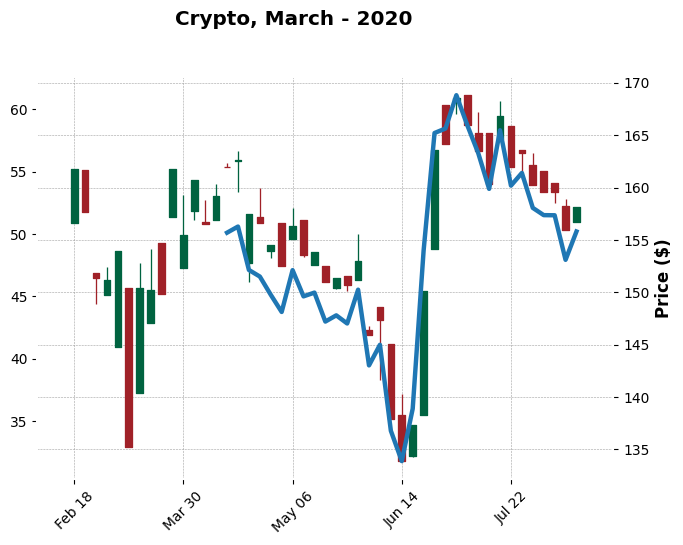

In [90]:
rsi = fplt.make_addplot(ohlc_data_frame["RSI"])

fplt.plot(
            ohlc_data_frame,
            type='candle',
            addplot = rsi,
            style='charles',
            title='Crypto, March - 2020',
            ylabel='Price ($)',
            )